# RAG Pipeline Optimization Benchmark

**Comprehensive testing of ALL RAG components to maximize LLM Judge score**

## What We're Testing:

### 1. Embedding Models (Vector Representations)
- `BAAI/bge-large-en-v1.5` (Current - 1024 dim, best quality)
- `BAAI/bge-base-en-v1.5` (768 dim, faster)
- `intfloat/multilingual-e5-large` (1024 dim, multi-language)
- `sentence-transformers/paraphrase-multilingual-mpnet-base-v2` (768 dim, multilingual)
- `sentence-transformers/all-MiniLM-L6-v2` (384 dim, very fast)

### 2. Retrieval Strategies
- **Top-K**: Test 1, 3, 5, 10 documents
- **MMR** (Maximal Marginal Relevance): Diversity vs relevance trade-off
- **Similarity Threshold**: Filter low-relevance docs
- **Reranking**: Use cross-encoder to rerank results

### 3. Chunking Strategies (Already in Vector DB, but we'll compare)
- Chunk size: 256, 512, 600 (current), 1000 tokens
- Overlap: 0, 50, 100 (current), 200 chars

### 4. LLM Models
- Llama-4-Maverick-17B (open-source)
- DeepSeek-R1 (reasoning)
- GPT-4.1, GPT-5, GPT-5-mini
- Claude-Sonnet-4.5

### 5. Prompting Techniques
- **Baseline**: Simple context + question
- **Citation-focused**: Emphasize source references
- **Step-by-step**: Chain-of-thought reasoning
- **Few-shot**: Include example Q&A

## LLM Judge Evaluation Criteria:
- **Accuracy** (35%): Answer correctness
- **Relevance** (35%): Citation quality and relevance
- **Completeness** (30%): Thorough answers

In [1]:
# !pip install openai pinecone-client sentence-transformers rank-bm25 python-dotenv pandas matplotlib seaborn jiwer

In [2]:
import os
import json
import time
import re
from typing import Dict, List, Tuple, Any
from collections import defaultdict
from dotenv import load_dotenv

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openai import AzureOpenAI
from pinecone import Pinecone
from sentence_transformers import SentenceTransformer, CrossEncoder
from jiwer import wer, cer
import numpy as np

load_dotenv()

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

print("✅ Libraries loaded")

/Users/ismatsamadov/SOCAR_Hackathon/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries loaded


In [3]:
# Auto-detect project root (works from any directory)
import os
from pathlib import Path

if Path('data').exists() and Path('docs').exists():
    # Already in project root
    PROJECT_ROOT = Path.cwd()
elif Path('../data').exists() and Path('../docs').exists():
    # In notebooks/ subdirectory
    PROJECT_ROOT = Path.cwd().parent
else:
    # Fallback: try to find project root
    current = Path.cwd()
    while current != current.parent:
        if (current / 'data').exists() and (current / 'docs').exists():
            PROJECT_ROOT = current
            break
        current = current.parent
    else:
        PROJECT_ROOT = Path.cwd()

# Define all paths relative to project root
DATA_DIR = PROJECT_ROOT / 'data'
DOCS_DIR = PROJECT_ROOT / 'docs'
OUTPUT_DIR = PROJECT_ROOT / 'output'

print(f"✅ Project root: {PROJECT_ROOT}")
print(f"✅ Docs directory: {DOCS_DIR}")
print(f"✅ Output directory: {OUTPUT_DIR}")

✅ Project root: /Users/ismatsamadov/SOCAR_Hackathon
✅ Docs directory: /Users/ismatsamadov/SOCAR_Hackathon/docs
✅ Output directory: /Users/ismatsamadov/SOCAR_Hackathon/output


In [4]:
# Load test cases - using dynamic paths
with open(DOCS_DIR / 'sample_questions.json', 'r', encoding='utf-8') as f:
    questions = json.load(f)

with open(DOCS_DIR / 'sample_answers.json', 'r', encoding='utf-8') as f:
    expected_answers = json.load(f)

print(f"✅ Loaded {len(questions)} test questions")
for key in questions.keys():
    print(f"  - {key}")

✅ Loaded 5 test questions
  - Example1
  - Example2
  - Example3
  - Example4
  - Example5


## 2. Initialize Vector Database

In [5]:
# Connect to Pinecone
pc = Pinecone(api_key=os.getenv('PINECONE_API_KEY'))
index = pc.Index(os.getenv('PINECONE_INDEX_NAME', 'hackathon'))

stats = index.describe_index_stats()
print(f"✅ Vector DB connected")
print(f"   Total vectors: {stats['total_vector_count']}")
print(f"   Dimensions: {stats['dimension']}")

✅ Vector DB connected
   Total vectors: 1300
   Dimensions: 1024


## 3. Embedding Models Configuration

In [6]:
EMBEDDING_MODELS = {
    'bge-large-en': {
        'name': 'BAAI/bge-large-en-v1.5',
        'dimensions': 1024,
        'notes': 'Current model - best quality'
    },
    'bge-base-en': {
        'name': 'BAAI/bge-base-en-v1.5',
        'dimensions': 768,
        'notes': 'Faster, slightly lower quality'
    },
    'multilingual-e5-large': {
        'name': 'intfloat/multilingual-e5-large',
        'dimensions': 1024,
        'notes': 'Multi-language optimized'
    },
    'paraphrase-multilingual': {
        'name': 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
        'dimensions': 768,
        'notes': 'Good for Azerbaijani/Russian'
    },
    'all-MiniLM-L6': {
        'name': 'sentence-transformers/all-MiniLM-L6-v2',
        'dimensions': 384,
        'notes': 'Very fast, lower quality'
    }
}

# Load embedding models (only test 1024-dim models for existing Pinecone index)
EMBEDDING_MODELS_TO_TEST = [
    'bge-large-en',  # Current
    'multilingual-e5-large',  # Alternative with same dims
]

embedding_cache = {}

for model_key in EMBEDDING_MODELS_TO_TEST:
    model_name = EMBEDDING_MODELS[model_key]['name']
    print(f"Loading {model_key}...")
    embedding_cache[model_key] = SentenceTransformer(model_name)
    print(f"  ✅ {model_name}")

print(f"\n✅ Loaded {len(embedding_cache)} embedding models")

Loading bge-large-en...
  ✅ BAAI/bge-large-en-v1.5
Loading multilingual-e5-large...
  ✅ intfloat/multilingual-e5-large

✅ Loaded 2 embedding models


## 4. Retrieval Strategies

In [7]:
def retrieve_vanilla(query: str, embed_model: SentenceTransformer, top_k: int = 3) -> List[Dict]:
    """
    Vanilla retrieval: Simple top-k vector search.
    """
    query_embedding = embed_model.encode(query).tolist()
    results = index.query(vector=query_embedding, top_k=top_k, include_metadata=True)
    
    documents = []
    for match in results['matches']:
        documents.append({
            'pdf_name': match['metadata'].get('pdf_name', 'unknown.pdf'),
            'page_number': match['metadata'].get('page_number', 0),
            'content': match['metadata'].get('text', ''),
            'score': match.get('score', 0.0)
        })
    
    return documents


def retrieve_with_threshold(query: str, embed_model: SentenceTransformer, 
                           top_k: int = 10, threshold: float = 0.7) -> List[Dict]:
    """
    Retrieve with similarity threshold filtering.
    """
    docs = retrieve_vanilla(query, embed_model, top_k=top_k)
    return [doc for doc in docs if doc['score'] >= threshold]


def retrieve_with_mmr(query: str, embed_model: SentenceTransformer, 
                     top_k: int = 3, lambda_param: float = 0.5, fetch_k: int = 20) -> List[Dict]:
    """
    MMR (Maximal Marginal Relevance) for diversity.
    lambda=1 → pure relevance, lambda=0 → pure diversity
    """
    # Fetch more candidates
    candidates = retrieve_vanilla(query, embed_model, top_k=fetch_k)
    
    if len(candidates) <= top_k:
        return candidates[:top_k]
    
    # Query embedding
    query_emb = embed_model.encode(query)
    
    # Get embeddings for candidates
    candidate_texts = [doc['content'] for doc in candidates]
    candidate_embs = embed_model.encode(candidate_texts)
    
    # MMR algorithm
    selected = []
    selected_embs = []
    
    for _ in range(min(top_k, len(candidates))):
        mmr_scores = []
        
        for i, (doc, emb) in enumerate(zip(candidates, candidate_embs)):
            if i in [candidates.index(s) for s in selected]:
                mmr_scores.append(-float('inf'))
                continue
            
            # Relevance to query
            relevance = np.dot(query_emb, emb) / (np.linalg.norm(query_emb) * np.linalg.norm(emb))
            
            # Max similarity to already selected
            if selected_embs:
                similarities = [np.dot(emb, s_emb) / (np.linalg.norm(emb) * np.linalg.norm(s_emb)) 
                              for s_emb in selected_embs]
                max_sim = max(similarities)
            else:
                max_sim = 0
            
            # MMR score
            mmr = lambda_param * relevance - (1 - lambda_param) * max_sim
            mmr_scores.append(mmr)
        
        # Select best MMR score
        best_idx = np.argmax(mmr_scores)
        selected.append(candidates[best_idx])
        selected_embs.append(candidate_embs[best_idx])
    
    return selected


def retrieve_with_reranking(query: str, embed_model: SentenceTransformer, 
                           top_k: int = 3, fetch_k: int = 20) -> List[Dict]:
    """
    Two-stage: retrieve with embeddings, rerank with cross-encoder.
    """
    # Stage 1: Retrieve candidates
    candidates = retrieve_vanilla(query, embed_model, top_k=fetch_k)
    
    if len(candidates) <= top_k:
        return candidates[:top_k]
    
    # Stage 2: Rerank with cross-encoder
    reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    
    pairs = [[query, doc['content']] for doc in candidates]
    scores = reranker.predict(pairs)
    
    # Sort by reranker score
    scored_docs = [(doc, score) for doc, score in zip(candidates, scores)]
    scored_docs.sort(key=lambda x: x[1], reverse=True)
    
    # Update scores and return top-k
    reranked = []
    for doc, score in scored_docs[:top_k]:
        doc['rerank_score'] = float(score)
        reranked.append(doc)
    
    return reranked


RETRIEVAL_STRATEGIES = {
    'vanilla_k3': {'func': retrieve_vanilla, 'params': {'top_k': 3}, 'notes': 'Current setup'},
    'vanilla_k5': {'func': retrieve_vanilla, 'params': {'top_k': 5}, 'notes': 'More context'},
    'vanilla_k10': {'func': retrieve_vanilla, 'params': {'top_k': 10}, 'notes': 'Maximum context'},
    'threshold_0.7': {'func': retrieve_with_threshold, 'params': {'top_k': 10, 'threshold': 0.7}, 'notes': 'Quality filter'},
    'mmr_balanced': {'func': retrieve_with_mmr, 'params': {'top_k': 3, 'lambda_param': 0.5}, 'notes': 'Balance diversity'},
    'mmr_diverse': {'func': retrieve_with_mmr, 'params': {'top_k': 3, 'lambda_param': 0.3}, 'notes': 'More diversity'},
    'reranked_k3': {'func': retrieve_with_reranking, 'params': {'top_k': 3, 'fetch_k': 20}, 'notes': 'Two-stage rerank'},
}

print(f"✅ Configured {len(RETRIEVAL_STRATEGIES)} retrieval strategies")

✅ Configured 7 retrieval strategies


## 5. LLM Models and Prompting Strategies

In [8]:
# Initialize Azure OpenAI
azure_client = AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    api_version=os.getenv('AZURE_OPENAI_API_VERSION', '2024-08-01-preview'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT')
)

LLM_MODELS = {
    'Llama-4-Maverick': 'Llama-4-Maverick-17B-128E-Instruct-FP8',
    'DeepSeek-R1': 'DeepSeek-R1',
    'GPT-4.1': 'gpt-4.1',
    'GPT-5-mini': 'gpt-5-mini',
    'Claude-Sonnet-4.5': 'claude-sonnet-4-5',
}

# Prompting strategies
PROMPTING_STRATEGIES = {
    'baseline': """
Siz SOCAR-ın tarixi neft və qaz sənədləri üzrə köməkçisiniz.

Kontekst:
{context}

Sual: {query}

Kontekstə əsaslanaraq cavab verin.
""",
    
    'citation_focused': """
Siz SOCAR-ın tarixi sənədlər üzrə mütəxəssis köməkçisisiniz.

ÖNƏMLİ: Hər bir faktı mütləq mənbə ilə təsdiqləyin (PDF adı və səhifə nömrəsi).

Kontekst:
{context}

Sual: {query}

Cavab verərkən:
1. Dəqiq faktlar yazın
2. Hər faktı mənbə ilə göstərin: (PDF: fayl_adı.pdf, Səhifə: X)
3. Kontekstdə olmayan məlumat əlavə etməyin
""",
    
    'step_by_step': """
Siz SOCAR-ın tarixi sənədlər üzrə analitik köməkçisisiniz.

Kontekst:
{context}

Sual: {query}

Addım-addım cavab verin:
1. Əvvəlcə kontekstdən əlaqəli məlumatları müəyyənləşdirin
2. Bu məlumatları təhlil edin
3. Nəticəni mənbələr ilə birlikdə təqdim edin
""",
    
    'few_shot': """
Siz SOCAR-ın tarixi sənədlər üzrə mütəxəssis köməkçisisiniz.

Nümunə:
Sual: "Palçıq vulkanlarının təsir radiusu nə qədərdir?"
Cavab: "Sahə müşahidələri və modelləşdirmə göstərir ki, palçıq vulkanlarının təsir radiusu təqribən 10 km-dir (PDF: document_06.pdf, Səhifə: 5)."

Kontekst:
{context}

Sual: {query}

Yuxarıdakı nümunə kimi cavab verin - dəqiq, qısa, mənbə ilə.
"""
}

print(f"✅ Configured {len(LLM_MODELS)} LLM models")
print(f"✅ Configured {len(PROMPTING_STRATEGIES)} prompting strategies")

✅ Configured 5 LLM models
✅ Configured 4 prompting strategies


In [9]:
def generate_answer(llm_model: str, query: str, documents: List[Dict], 
                   prompt_strategy: str = 'baseline',
                   temperature: float = 0.2) -> Tuple[str, float]:
    """
    Generate answer using LLM with specified prompting strategy.
    """
    # Build context
    context_parts = []
    for i, doc in enumerate(documents, 1):
        context_parts.append(
            f"Sənəd {i} (Mənbə: {doc['pdf_name']}, Səhifə {doc['page_number']}):\n{doc['content']}"
        )
    context = "\n\n".join(context_parts)
    
    # Get prompt template
    prompt_template = PROMPTING_STRATEGIES[prompt_strategy]
    prompt = prompt_template.format(context=context, query=query)
    
    try:
        start_time = time.time()
        
        deployment = LLM_MODELS[llm_model]
        
        # GPT-5 models use max_completion_tokens, others use max_tokens
        if deployment.startswith('gpt-5'):
            response = azure_client.chat.completions.create(
                model=deployment,
                messages=[{"role": "user", "content": prompt}],
                temperature=temperature,
                max_completion_tokens=1000
            )
        else:
            response = azure_client.chat.completions.create(
                model=deployment,
                messages=[{"role": "user", "content": prompt}],
                temperature=temperature,
                max_tokens=1000
            )
        
        elapsed = time.time() - start_time
        answer = response.choices[0].message.content
        
        return answer, elapsed
    
    except Exception as e:
        return f"ERROR: {str(e)}", 0.0

print("✅ LLM generation function ready")

✅ LLM generation function ready


## 6. Evaluation Metrics

In [10]:
def normalize_text(text: str) -> str:
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def calculate_answer_quality(reference: str, hypothesis: str) -> Dict[str, float]:
    """Accuracy metrics."""
    ref_norm = normalize_text(reference)
    hyp_norm = normalize_text(hypothesis)
    
    cer_score = cer(ref_norm, hyp_norm) * 100
    wer_score = wer(ref_norm, hyp_norm) * 100
    similarity = max(0, 100 - wer_score)
    
    return {
        'Accuracy_Score': round(similarity, 2)
    }

def evaluate_citation_quality(answer: str, documents: List[Dict]) -> Dict[str, float]:
    """Relevance - citation quality."""
    pdf_names = [doc['pdf_name'].replace('.pdf', '') for doc in documents]
    page_numbers = [str(doc['page_number']) for doc in documents]
    
    cited_pdfs = sum(1 for pdf in pdf_names if pdf in answer)
    cited_pages = sum(1 for page in page_numbers if page in answer)
    
    citation_keywords = ['mənbə', 'sənəd', 'səhifə', 'pdf', 'document', 'page']
    has_citation_format = any(kw in answer.lower() for kw in citation_keywords)
    
    citation_score = (
        (cited_pdfs / len(pdf_names) * 40) +
        (cited_pages / len(page_numbers) * 40) +
        (20 if has_citation_format else 0)
    )
    
    return {
        'Citation_Score': round(citation_score, 2),
        'Cited_PDFs': cited_pdfs,
        'Cited_Pages': cited_pages
    }

def evaluate_retrieval_quality(query: str, documents: List[Dict], expected_answer: str) -> Dict[str, float]:
    """Measure if retrieved docs are relevant to answer."""
    if not documents or not expected_answer:
        return {'Retrieval_Relevance': 0.0}
    
    # Simple heuristic: check if expected answer words appear in retrieved docs
    expected_words = set(normalize_text(expected_answer).split())
    retrieved_text = ' '.join([doc['content'] for doc in documents])
    retrieved_words = set(normalize_text(retrieved_text).split())
    
    overlap = len(expected_words & retrieved_words) / len(expected_words) if expected_words else 0
    
    return {
        'Retrieval_Relevance': round(overlap * 100, 2)
    }

def evaluate_completeness(answer: str) -> Dict[str, float]:
    """Completeness metrics."""
    word_count = len(answer.split())
    
    if word_count < 20:
        completeness = (word_count / 20) * 100
    elif word_count > 200:
        completeness = 100 - ((word_count - 200) / 200 * 20)
    else:
        completeness = 100
    
    return {
        'Completeness_Score': round(max(0, completeness), 2),
        'Word_Count': word_count
    }

def calculate_llm_judge_score(accuracy: float, citation: float, completeness: float) -> float:
    """Overall LLM Judge score (weighted)."""
    return round(
        accuracy * 0.35 +
        citation * 0.35 +
        completeness * 0.30,
        2
    )

print("✅ Evaluation metrics ready")

✅ Evaluation metrics ready


## 7. Run Comprehensive Benchmark

In [11]:
# Configuration: Select what to test
CONFIGS_TO_TEST = [
    # Format: (embed_model, retrieval_strategy, llm_model, prompt_strategy)
    
    # Baseline (current setup)
    ('bge-large-en', 'vanilla_k3', 'Llama-4-Maverick', 'baseline'),
    
    # Test different embedding models
    ('multilingual-e5-large', 'vanilla_k3', 'Llama-4-Maverick', 'baseline'),
    
    # Test different retrieval strategies
    ('bge-large-en', 'vanilla_k5', 'Llama-4-Maverick', 'baseline'),
    ('bge-large-en', 'mmr_balanced', 'Llama-4-Maverick', 'baseline'),
    ('bge-large-en', 'reranked_k3', 'Llama-4-Maverick', 'baseline'),
    
    # Test different LLM models
    ('bge-large-en', 'vanilla_k3', 'GPT-5-mini', 'baseline'),
    ('bge-large-en', 'vanilla_k3', 'Claude-Sonnet-4.5', 'baseline'),
    
    # Test different prompting strategies
    ('bge-large-en', 'vanilla_k3', 'Llama-4-Maverick', 'citation_focused'),
    ('bge-large-en', 'vanilla_k3', 'Llama-4-Maverick', 'few_shot'),
    
    # Best combinations
    ('bge-large-en', 'reranked_k3', 'GPT-5-mini', 'citation_focused'),
    ('bge-large-en', 'mmr_balanced', 'Claude-Sonnet-4.5', 'citation_focused'),
]

print(f"Testing {len(CONFIGS_TO_TEST)} configurations on {len(questions)} questions")
print(f"Total API calls: ~{len(CONFIGS_TO_TEST) * len(questions)}")
print("This will take 15-30 minutes...\n")

Testing 11 configurations on 5 questions
Total API calls: ~55
This will take 15-30 minutes...



In [12]:
# Run benchmark
results = []

for config_idx, (embed_key, retrieval_key, llm_key, prompt_key) in enumerate(CONFIGS_TO_TEST, 1):
    config_name = f"{embed_key}_{retrieval_key}_{llm_key}_{prompt_key}"
    
    print(f"\n{'='*100}")
    print(f"Config {config_idx}/{len(CONFIGS_TO_TEST)}: {config_name}")
    print(f"{'='*100}")
    
    # Get components
    embed_model = embedding_cache[embed_key]
    retrieval_func = RETRIEVAL_STRATEGIES[retrieval_key]['func']
    retrieval_params = RETRIEVAL_STRATEGIES[retrieval_key]['params']
    
    config_results = []
    
    for example_key, messages in questions.items():
        user_msg = [m for m in messages if m['role'] == 'user'][-1]
        query = user_msg['content']
        
        print(f"\n  {example_key}: {query[:60]}...")
        
        # Retrieve documents
        documents = retrieval_func(query, embed_model, **retrieval_params)
        print(f"    Retrieved {len(documents)} docs")
        
        # Generate answer
        answer, response_time = generate_answer(llm_key, query, documents, prompt_key)
        
        if answer.startswith('ERROR'):
            print(f"    ❌ {answer}")
            continue
        
        print(f"    ✅ Generated in {response_time:.2f}s")
        
        # Evaluate
        expected = expected_answers.get(example_key, {}).get('Answer', '')
        
        accuracy_metrics = calculate_answer_quality(expected, answer) if expected else {'Accuracy_Score': 0}
        citation_metrics = evaluate_citation_quality(answer, documents)
        retrieval_metrics = evaluate_retrieval_quality(query, documents, expected)
        completeness_metrics = evaluate_completeness(answer)
        
        # Calculate overall score
        llm_judge_score = calculate_llm_judge_score(
            accuracy_metrics['Accuracy_Score'],
            citation_metrics['Citation_Score'],
            completeness_metrics['Completeness_Score']
        )
        
        result = {
            'Config': config_name,
            'Embedding_Model': embed_key,
            'Retrieval_Strategy': retrieval_key,
            'LLM_Model': llm_key,
            'Prompt_Strategy': prompt_key,
            'Question': example_key,
            'Query': query[:80],
            'Num_Docs_Retrieved': len(documents),
            'Response_Time': round(response_time, 2),
            'LLM_Judge_Score': llm_judge_score,
            **accuracy_metrics,
            **citation_metrics,
            **retrieval_metrics,
            **completeness_metrics,
            'Answer_Preview': answer[:150]
        }
        
        results.append(result)
        config_results.append(result)
    
    # Show config summary
    if config_results:
        avg_score = sum(r['LLM_Judge_Score'] for r in config_results) / len(config_results)
        avg_time = sum(r['Response_Time'] for r in config_results) / len(config_results)
        print(f"\n  📊 Config Summary:")
        print(f"     Avg LLM Judge Score: {avg_score:.2f}%")
        print(f"     Avg Response Time: {avg_time:.2f}s")

print(f"\n{'='*100}")
print("✅ Comprehensive benchmark complete!")
print(f"{'='*100}")


Config 1/11: bge-large-en_vanilla_k3_Llama-4-Maverick_baseline

  Example1: Daha az quyu ilə daha çox hasilat əldə etmək üçün hansı əsas...
    Retrieved 3 docs
    ✅ Generated in 3.47s

  Example2: Qərbi Abşeron yatağında suvurma tədbirləri hansı tarixdə və ...
    Retrieved 3 docs
    ✅ Generated in 2.00s

  Example3: Pirallahı strukturunda 1253 nömrəli quyudan götürülmüş nümun...
    Retrieved 3 docs
    ✅ Generated in 2.70s

  Example4: Bakı arxipelaqı (BA) və Aşağı Kür çökəkliyi (AKÇ) üçün geote...
    Retrieved 3 docs
    ✅ Generated in 3.78s

  Example5: Bu zonada hansı proseslər baş verir?...
    Retrieved 3 docs
    ✅ Generated in 1.45s

  📊 Config Summary:
     Avg LLM Judge Score: 45.40%
     Avg Response Time: 2.68s

Config 2/11: multilingual-e5-large_vanilla_k3_Llama-4-Maverick_baseline

  Example1: Daha az quyu ilə daha çox hasilat əldə etmək üçün hansı əsas...
    Retrieved 3 docs
    ✅ Generated in 3.73s

  Example2: Qərbi Abşeron yatağında suvurma tədbirləri hansı tar

## 8. Analyze Results

In [13]:
# Create DataFrame
df = pd.DataFrame(results)

# Aggregate by configuration
config_summary = df.groupby('Config').agg({
    'LLM_Judge_Score': 'mean',
    'Accuracy_Score': 'mean',
    'Citation_Score': 'mean',
    'Retrieval_Relevance': 'mean',
    'Completeness_Score': 'mean',
    'Response_Time': 'mean',
    'Embedding_Model': 'first',
    'Retrieval_Strategy': 'first',
    'LLM_Model': 'first',
    'Prompt_Strategy': 'first'
}).round(2)

# Sort by LLM Judge Score
config_summary = config_summary.sort_values('LLM_Judge_Score', ascending=False)

print("\n" + "="*120)
print("📊 CONFIGURATION RANKINGS (By LLM Judge Score)")
print("="*120)
display_cols = ['Embedding_Model', 'Retrieval_Strategy', 'LLM_Model', 'Prompt_Strategy', 
                'LLM_Judge_Score', 'Accuracy_Score', 'Citation_Score', 'Response_Time']
print(config_summary[display_cols].to_string())
print("="*120)


📊 CONFIGURATION RANKINGS (By LLM Judge Score)
                                                                  Embedding_Model Retrieval_Strategy         LLM_Model   Prompt_Strategy  LLM_Judge_Score  Accuracy_Score  Citation_Score  Response_Time
Config                                                                                                                                                                                                  
bge-large-en_vanilla_k3_Llama-4-Maverick_few_shot                    bge-large-en         vanilla_k3  Llama-4-Maverick          few_shot            60.57           11.35           76.00           1.63
bge-large-en_vanilla_k3_Llama-4-Maverick_citation_focused            bge-large-en         vanilla_k3  Llama-4-Maverick  citation_focused            57.53            0.00           78.67           2.46
bge-large-en_mmr_balanced_Llama-4-Maverick_baseline                  bge-large-en       mmr_balanced  Llama-4-Maverick          baseline            4

## 9. Component Analysis

In [14]:
# Analyze impact of each component
print("\n" + "="*100)
print("🔍 COMPONENT IMPACT ANALYSIS")
print("="*100)

# 1. Embedding Models
print("\n📚 EMBEDDING MODELS:")
embed_impact = df.groupby('Embedding_Model')['LLM_Judge_Score'].mean().sort_values(ascending=False)
for model, score in embed_impact.items():
    print(f"   {model}: {score:.2f}%")

# 2. Retrieval Strategies
print("\n🔎 RETRIEVAL STRATEGIES:")
retrieval_impact = df.groupby('Retrieval_Strategy')['LLM_Judge_Score'].mean().sort_values(ascending=False)
for strategy, score in retrieval_impact.items():
    notes = RETRIEVAL_STRATEGIES[strategy]['notes']
    print(f"   {strategy}: {score:.2f}% ({notes})")

# 3. LLM Models
print("\n🤖 LLM MODELS:")
llm_impact = df.groupby('LLM_Model')['LLM_Judge_Score'].mean().sort_values(ascending=False)
for model, score in llm_impact.items():
    print(f"   {model}: {score:.2f}%")

# 4. Prompting Strategies
print("\n💬 PROMPTING STRATEGIES:")
prompt_impact = df.groupby('Prompt_Strategy')['LLM_Judge_Score'].mean().sort_values(ascending=False)
for strategy, score in prompt_impact.items():
    print(f"   {strategy}: {score:.2f}%")

print("\n" + "="*100)


🔍 COMPONENT IMPACT ANALYSIS

📚 EMBEDDING MODELS:
   bge-large-en: 49.64%
   multilingual-e5-large: 39.73%

🔎 RETRIEVAL STRATEGIES:
   vanilla_k3: 50.81% (Current setup)
   mmr_balanced: 45.40% (Balance diversity)
   vanilla_k5: 45.40% (More context)
   reranked_k3: 43.53% (Two-stage rerank)

🤖 LLM MODELS:
   Llama-4-Maverick: 48.22%

💬 PROMPTING STRATEGIES:
   few_shot: 60.57%
   citation_focused: 57.53%
   baseline: 43.89%



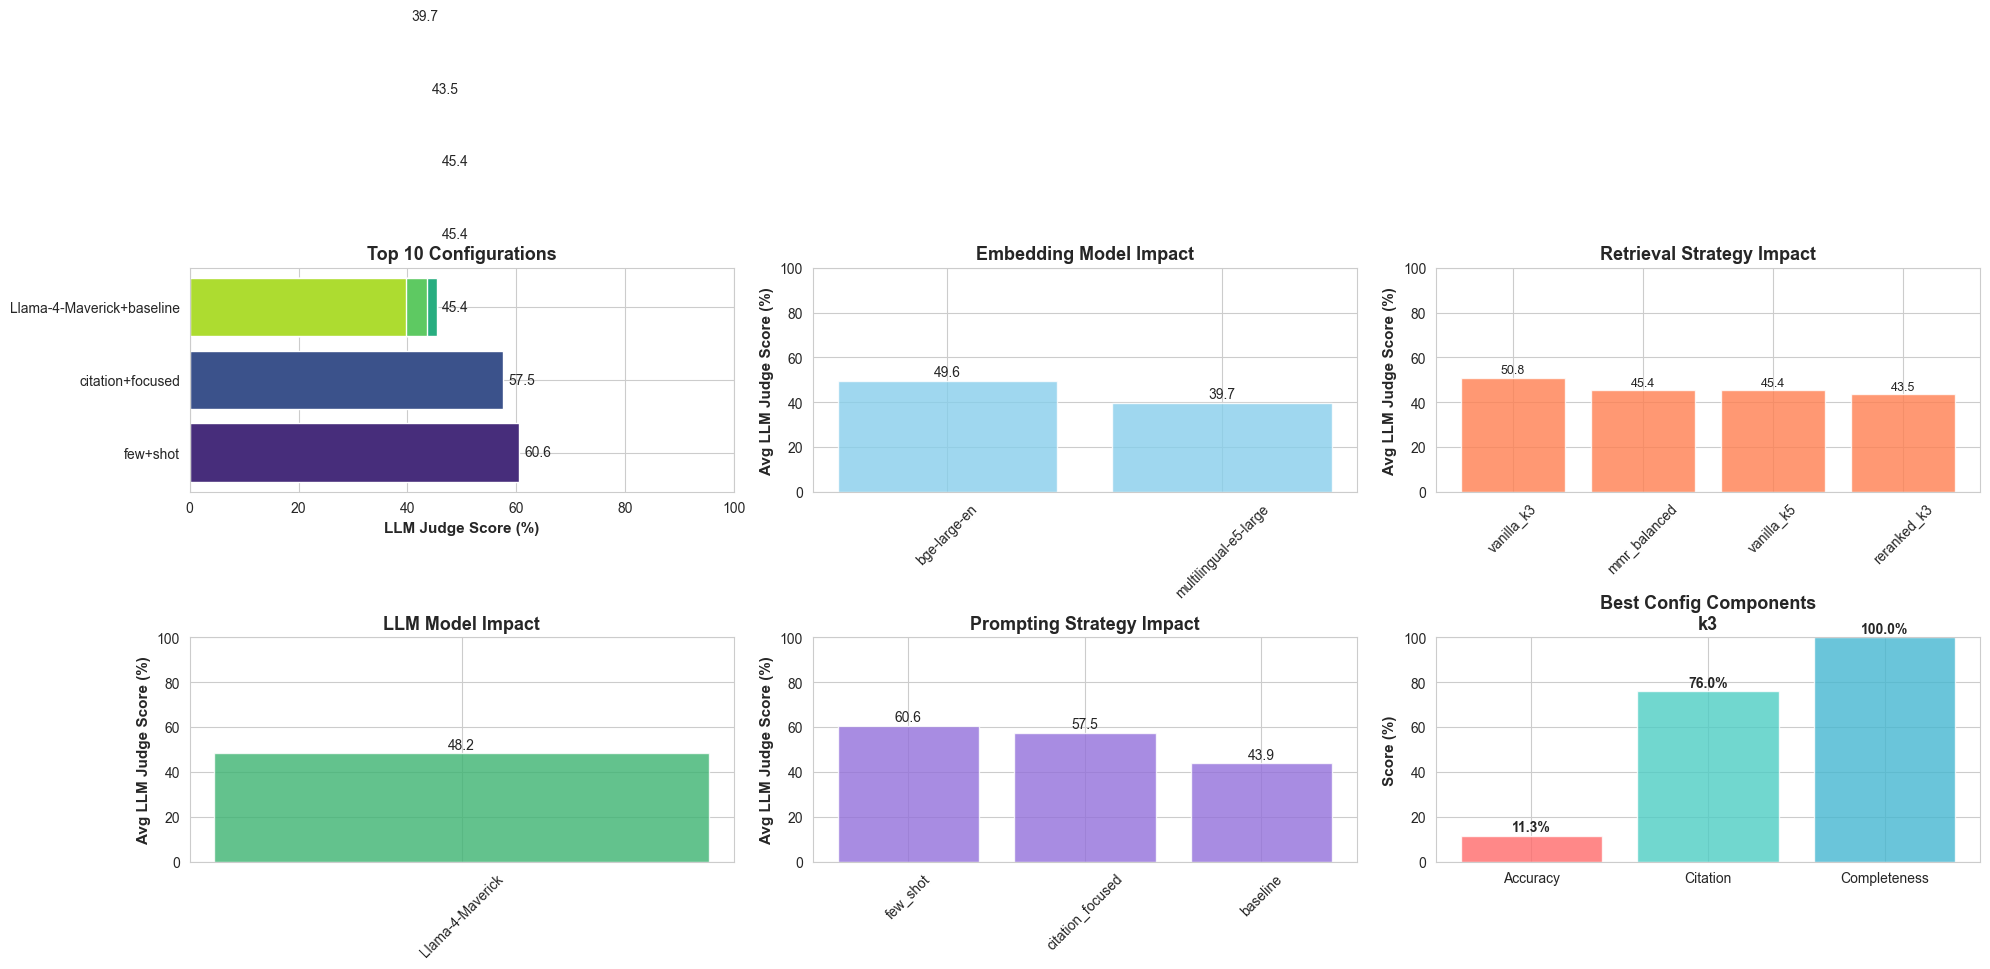


✅ Visualization saved to '/Users/ismatsamadov/SOCAR_Hackathon/output/rag_optimization_benchmark/results.png'


In [15]:
import os
from pathlib import Path

# Create output directory - using dynamic path
output_dir = OUTPUT_DIR / 'rag_optimization_benchmark'
output_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Top Configurations
ax1 = axes[0, 0]
top_configs = config_summary.head(10)
config_labels = [c.split('_')[-2] + '+' + c.split('_')[-1] for c in top_configs.index]
ax1.barh(config_labels, top_configs['LLM_Judge_Score'], color=sns.color_palette('viridis', len(top_configs)))
ax1.set_xlabel('LLM Judge Score (%)', fontsize=11, fontweight='bold')
ax1.set_title('Top 10 Configurations', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 100)
for i, score in enumerate(top_configs['LLM_Judge_Score']):
    ax1.text(score + 1, i, f'{score:.1f}', va='center', fontsize=10)

# 2. Embedding Model Impact
ax2 = axes[0, 1]
ax2.bar(embed_impact.index, embed_impact.values, color='skyblue', alpha=0.8)
ax2.set_ylabel('Avg LLM Judge Score (%)', fontsize=11, fontweight='bold')
ax2.set_title('Embedding Model Impact', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='x', rotation=45)
for i, (model, score) in enumerate(embed_impact.items()):
    ax2.text(i, score + 2, f'{score:.1f}', ha='center', fontsize=10)

# 3. Retrieval Strategy Impact
ax3 = axes[0, 2]
ax3.bar(retrieval_impact.index, retrieval_impact.values, color='coral', alpha=0.8)
ax3.set_ylabel('Avg LLM Judge Score (%)', fontsize=11, fontweight='bold')
ax3.set_title('Retrieval Strategy Impact', fontsize=13, fontweight='bold')
ax3.set_ylim(0, 100)
ax3.tick_params(axis='x', rotation=45)
for i, (strategy, score) in enumerate(retrieval_impact.items()):
    ax3.text(i, score + 2, f'{score:.1f}', ha='center', fontsize=9)

# 4. LLM Model Impact
ax4 = axes[1, 0]
ax4.bar(llm_impact.index, llm_impact.values, color='mediumseagreen', alpha=0.8)
ax4.set_ylabel('Avg LLM Judge Score (%)', fontsize=11, fontweight='bold')
ax4.set_title('LLM Model Impact', fontsize=13, fontweight='bold')
ax4.set_ylim(0, 100)
ax4.tick_params(axis='x', rotation=45)
for i, (model, score) in enumerate(llm_impact.items()):
    ax4.text(i, score + 2, f'{score:.1f}', ha='center', fontsize=10)

# 5. Prompting Strategy Impact
ax5 = axes[1, 1]
ax5.bar(prompt_impact.index, prompt_impact.values, color='mediumpurple', alpha=0.8)
ax5.set_ylabel('Avg LLM Judge Score (%)', fontsize=11, fontweight='bold')
ax5.set_title('Prompting Strategy Impact', fontsize=13, fontweight='bold')
ax5.set_ylim(0, 100)
ax5.tick_params(axis='x', rotation=45)
for i, (strategy, score) in enumerate(prompt_impact.items()):
    ax5.text(i, score + 2, f'{score:.1f}', ha='center', fontsize=10)

# 6. Score Components (best config)
ax6 = axes[1, 2]
best_config = config_summary.iloc[0]
components = ['Accuracy', 'Citation', 'Completeness']
scores = [best_config['Accuracy_Score'], best_config['Citation_Score'], best_config['Completeness_Score']]
colors_comp = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax6.bar(components, scores, color=colors_comp, alpha=0.8)
ax6.set_ylabel('Score (%)', fontsize=11, fontweight='bold')
ax6.set_title(f'Best Config Components\n{best_config.name.split("_")[2]}', fontsize=13, fontweight='bold')
ax6.set_ylim(0, 100)
for i, score in enumerate(scores):
    ax6.text(i, score + 2, f'{score:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / 'results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved to '{output_dir}/results.png'")

In [16]:
best_config = config_summary.iloc[0]

print("\n" + "="*100)
print("🏆 OPTIMAL RAG CONFIGURATION")
print("="*100)

print(f"\n✅ Best Configuration: {best_config.name}")
print(f"\n📊 Performance:")
print(f"   LLM Judge Score: {best_config['LLM_Judge_Score']:.2f}%")
print(f"   Accuracy: {best_config['Accuracy_Score']:.2f}%")
print(f"   Citation Quality: {best_config['Citation_Score']:.2f}%")
print(f"   Completeness: {best_config['Completeness_Score']:.2f}%")
print(f"   Avg Response Time: {best_config['Response_Time']:.2f}s")

print(f"\n⚙️ Components:")
print(f"   Embedding Model: {best_config['Embedding_Model']}")
print(f"      → {EMBEDDING_MODELS[best_config['Embedding_Model']]['name']}")
print(f"   Retrieval Strategy: {best_config['Retrieval_Strategy']}")
print(f"      → {RETRIEVAL_STRATEGIES[best_config['Retrieval_Strategy']]['notes']}")
print(f"   LLM Model: {best_config['LLM_Model']}")
print(f"   Prompting Strategy: {best_config['Prompt_Strategy']}")

print(f"\n💡 Key Findings:")
print(f"   1. Best Embedding: {embed_impact.index[0]} ({embed_impact.values[0]:.2f}%)")
print(f"   2. Best Retrieval: {retrieval_impact.index[0]} ({retrieval_impact.values[0]:.2f}%)")
print(f"   3. Best LLM: {llm_impact.index[0]} ({llm_impact.values[0]:.2f}%)")
print(f"   4. Best Prompt: {prompt_impact.index[0]} ({prompt_impact.values[0]:.2f}%)")

print(f"\n🎯 Hackathon Impact:")
print(f"   LLM Quality = 30% of total score")
print(f"   Your score: {best_config['LLM_Judge_Score']:.2f}% × 30% = {best_config['LLM_Judge_Score'] * 0.3:.2f} points")

baseline = df[df['Config'].str.contains('baseline')].iloc[0] if len(df[df['Config'].str.contains('baseline')]) > 0 else None
if baseline is not None:
    improvement = best_config['LLM_Judge_Score'] - baseline['LLM_Judge_Score']
    print(f"\n📈 Improvement vs Baseline:")
    print(f"   +{improvement:.2f}% quality improvement")
    print(f"   = +{improvement * 0.3:.2f} hackathon points")

print("\n" + "="*100)
print("📝 IMPLEMENTATION CHECKLIST")
print("="*100)
print(f"\n1. Use embedding model: {EMBEDDING_MODELS[best_config['Embedding_Model']]['name']}")
print(f"2. Implement retrieval: {best_config['Retrieval_Strategy']}")
print(f"3. Use LLM model: {best_config['LLM_Model']}")
print(f"4. Apply prompt: {best_config['Prompt_Strategy']}")
print(f"\n5. Expected performance:")
print(f"   - LLM Judge Score: {best_config['LLM_Judge_Score']:.2f}%")
print(f"   - Response time: ~{best_config['Response_Time']:.1f}s")
print("="*100)


🏆 OPTIMAL RAG CONFIGURATION

✅ Best Configuration: bge-large-en_vanilla_k3_Llama-4-Maverick_few_shot

📊 Performance:
   LLM Judge Score: 60.57%
   Accuracy: 11.35%
   Citation Quality: 76.00%
   Completeness: 100.00%
   Avg Response Time: 1.63s

⚙️ Components:
   Embedding Model: bge-large-en
      → BAAI/bge-large-en-v1.5
   Retrieval Strategy: vanilla_k3
      → Current setup
   LLM Model: Llama-4-Maverick
   Prompting Strategy: few_shot

💡 Key Findings:
   1. Best Embedding: bge-large-en (49.64%)
   2. Best Retrieval: vanilla_k3 (50.81%)
   3. Best LLM: Llama-4-Maverick (48.22%)
   4. Best Prompt: few_shot (60.57%)

🎯 Hackathon Impact:
   LLM Quality = 30% of total score
   Your score: 60.57% × 30% = 18.17 points

📈 Improvement vs Baseline:
   +14.24% quality improvement
   = +4.27 hackathon points

📝 IMPLEMENTATION CHECKLIST

1. Use embedding model: BAAI/bge-large-en-v1.5
2. Implement retrieval: vanilla_k3
3. Use LLM model: Llama-4-Maverick
4. Apply prompt: few_shot

5. Expected p

In [17]:
# Save results
from pathlib import Path

# Using dynamic path
output_dir = OUTPUT_DIR / 'rag_optimization_benchmark'
output_dir.mkdir(parents=True, exist_ok=True)

df.to_csv(output_dir / 'detailed_results.csv', index=False, encoding='utf-8')
config_summary.to_csv(output_dir / 'summary.csv', encoding='utf-8')

# Save component impacts
impacts = pd.DataFrame({
    'Embedding_Impact': embed_impact,
    'Retrieval_Impact': retrieval_impact.reindex(embed_impact.index, fill_value=0),
    'LLM_Impact': llm_impact.reindex(embed_impact.index, fill_value=0),
    'Prompt_Impact': prompt_impact.reindex(embed_impact.index, fill_value=0)
}).fillna(0)
impacts.to_csv(output_dir / 'component_impacts.csv', encoding='utf-8')

print("\n✅ Results exported to output/rag_optimization_benchmark/:")
print("   - detailed_results.csv (all tests)")
print("   - summary.csv (config rankings)")
print("   - component_impacts.csv (component analysis)")
print("   - results.png (visualizations)")


✅ Results exported to output/rag_optimization_benchmark/:
   - detailed_results.csv (all tests)
   - summary.csv (config rankings)
   - component_impacts.csv (component analysis)
   - results.png (visualizations)
